In [117]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import tree

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Link to Assignment:
https://docs.google.com/document/d/1savsuz2g5zOVs9igef1dF5xuueomoS8Eow8Qr9rMifg/edit

# Task 1
Load the dataset into a Python notebook and test the performance of the following models:
a k-Nearest Neighbour
b Decision Tree
c Logistic Regression
d Random Forest


In [119]:
df = pd.read_csv('Dry_Bean_Dataset.csv')
df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653247,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [120]:
X = df.drop(columns='Class')
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test = StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(X_test)

### a. k-Nearest Neighbour

In [201]:
kNN = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='cosine')
kNN.fit(X_train, y_train)
y_pred = kNN.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.8942109903026741
Precision: 0.8942109903026741
Recall: 0.8942109903026741
F1: [0.90694239 0.99649123 0.92707046 0.87883864 0.93333333 0.93909627
 0.7961165 ]

Confusion Matrix:
[[307   0  23   1   3   3   7]
 [  0 142   0   0   0   0   0]
 [ 12   1 375   0  11   1   2]
 [  0   0   0 787   1  15  48]
 [  6   0   4   3 462   0  11]
 [  4   0   0  20   0 478  11]
 [  4   0   5 129  27   8 492]]


### b. Decision Tree

In [191]:
dT = DecisionTreeClassifier(min_impurity_decrease=0.0003)
dT.fit(X_train, y_train)
y_pred = dT.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.9097854833970026
Precision: 0.9097854833970026
Recall: 0.9097854833970026
F1: [0.89552239 1.         0.92307692 0.89905187 0.95607763 0.93506494
 0.84838963]

Confusion Matrix:
[[300   0  27   0   2   4  11]
 [  0 142   0   0   0   0   0]
 [ 18   0 372   0   9   2   1]
 [  0   0   0 806   3   6  36]
 [  4   0   3   4 468   0   7]
 [  2   0   0  30   0 468  13]
 [  2   0   2 102  11   8 540]]


### c. Logistic regression

In [192]:
lR = LogisticRegression(max_iter=30000)
lR.fit(X_train, y_train)
y_pred = lR.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.9230091096091684
Precision: 0.9230091096091684
Recall: 0.9230091096091684
F1: [0.91715976 1.         0.93969849 0.9109027  0.96494845 0.94613124
 0.8677014 ]

Confusion Matrix:
[[310   0  18   0   0   3  13]
 [  0 142   0   0   0   0   0]
 [ 14   0 374   0   7   2   5]
 [  0   0   0 777   1  12  61]
 [  2   0   2   4 468   0  10]
 [  5   0   0  13   0 483  12]
 [  1   0   0  61   8   8 587]]


### d. Randomforest

In [193]:
rFC = RandomForestClassifier(n_estimators=250, criterion='gini')
rFC.fit(X_train, y_train)
y_pred = rFC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.9177196591243021
Precision: 0.9177196591243021
Recall: 0.9177196591243021
F1: [0.91964286 1.         0.93416149 0.90241102 0.95786228 0.93596059
 0.86539924]

Confusion Matrix:
[[309   0  21   0   2   4   8]
 [  0 142   0   0   0   0   0]
 [ 14   0 376   0   8   2   2]
 [  0   0   0 786   2  12  51]
 [  3   0   6   4 466   0   7]
 [  2   0   0  23   0 475  13]
 [  0   0   0  78   9   9 569]]


### Discussion
tbd

# Task 2
Imagine that one of the bean types (‘Sira’) is moderately poisonous. How should you ‘nudge’ the performance of a classifier to address this? What evaluation metric is appropriate to capture this? Starting with the research resources linked below, identify a method to address this issue; test this method on the dataset. You don’t need to get perfect accuracy on the ‘Sira’ classification, the objective is to improve performance on the ‘Sira’ class without too much impact on the other classes. Discuss your findings in markdown. 


In [194]:
class_dist = df['Class'].value_counts()
class_dist

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64

Sira is already the second-largest class in the dataset by number of samples, therefore under- or oversampling though being viable are not strictly necessary. 
Instead, the weight of class Sira is increased by a factor of 10.

In [195]:
total_samples = len(df)
class_weights = {class_label: 1 for class_label, num_samples in class_dist.items()}
class_weights['SIRA'] = 10
class_weights

{'DERMASON': 1,
 'SIRA': 10,
 'SEKER': 1,
 'HOROZ': 1,
 'CALI': 1,
 'BARBUNYA': 1,
 'BOMBAY': 1}

Accuracy: 0.8921539817807816
Precision: 0.8921539817807816
Recall: 0.8921539817807816
F1: [0.91691395 1.         0.93552465 0.85319289 0.95319149 0.94630193
 0.80943513]

Confusion Matrix:


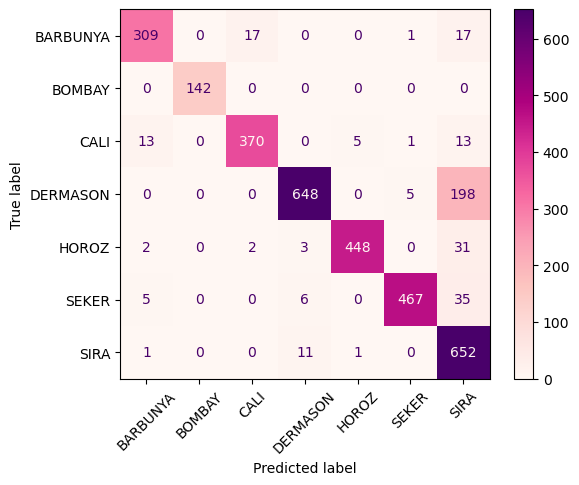

In [196]:
lR = LogisticRegression(max_iter=3000, class_weight=class_weights)
lR.fit(X_train, y_train)
y_pred = lR.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

#conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='RdPu', xticks_rotation=45.0)

print("\nConfusion Matrix:")
print(conf_matrix)

In [197]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
mcm

array([[[3038,   21],
        [  35,  309]],

       [[3261,    0],
        [   0,  142]],

       [[2982,   19],
        [  32,  370]],

       [[2532,   20],
        [ 203,  648]],

       [[2911,    6],
        [  38,  448]],

       [[2883,    7],
        [  46,  467]],

       [[2444,  294],
        [  13,  652]]])

In [198]:
recall_sira = round(mcm[6][1][1] / (mcm[6][1][0] + mcm[6][1][1]), 4)
recall_sira

0.9805